# Is a number odd or even?

### The problem
This is a common problem in computer science and real life. I often find myself looking at numbers and pondering whether they are odd or even. This lead me on a journey to provide a novel solution to the problem.

### The Approach
To answer the question of wether a number is odd or even we shall train a Deep Convolutional Neural Network to predict whether or not a hand written digit from the MNIST dataset is odd or even.

The network is relatively small with 135,137 trainable parameters.

### Assumptions
0 is an even number.

###  Results

The network achieves a high accuracy on the MNIST validation set and saves me hours of pondering whether a number is odd or even.

### Downsides
This network has no idea of the semantic meaning of odd or even but it sure knows what it looks like.


In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

import torchvision.utils as vutils


# use cuda if it is available
if torch.cuda.is_available():
    device = 'cuda:0'
    pin = True
else:
    device = 'cpu'
    pin = False

# Only need to known what labels are odd, increases speed ;) 
odd_nums = [1,3,5,7,9]

In [2]:
# transforms to be applied to the MNIST images
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [3]:
# get the MNIST data

# Set this to false if you do not have MNIST hand written digits already
got_MNIST = True

trainset = datasets.MNIST('.\data', download=not got_MNIST, train=True, transform=transform)
valset = datasets.MNIST('.\data', download=not got_MNIST, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, pin_memory=pin, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=True,  pin_memory=pin,  num_workers=2)

torch.Size([128, 1, 28, 28])
torch.Size([128])


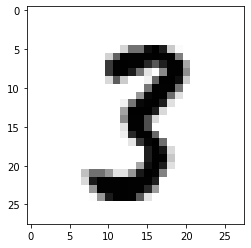

In [4]:
# lets look at the data and an example image

dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

In [5]:
# define the model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,  stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1, padding=0)
        
        self.fc1 = nn.Linear(128*2*2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)
        self.leaky_relu = nn.LeakyReLU()
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        

        x = self.conv1(x)
        x = self.leaky_relu(x)
    
        x = self.conv2(x)
        x = self.bn1(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.leaky_relu(x)
        


        x = self.conv3(x)
        x = self.bn2(x)
        x = F.max_pool2d(x, kernel_size=3, stride=1)
        x = self.leaky_relu(x)
        
        
        x = self.conv4(x)
        x = self.leaky_relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=1)
        
        # clamp(min=0) is the same as ReLU
        x = self.fc1(x.view(-1,128*2*2)).clamp(min=0)
        
        x = self.fc2(x).clamp(min=0)
        
        x = self.out(x)
        
        x = self.sigmoid(x)
    
        return x.squeeze()

In [6]:
# initialise the model and print some useful information about it

model = CNN().float().to(device)

print(model)
def count_parameters(model):
    total_param = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_param = np.prod(param.size())
            if param.dim() > 1:
                print(name, ':', 'x'.join(str(x) for x in list(param.size())), '=', num_param)
            else:
                print(name, ':', num_param)
            total_param += num_param
    print(f"There are {total_param} trainable parameters in the model.")

count_parameters(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (sigmoid): Sigmoid()
)
conv1.weight : 32x1x3x3 = 288
conv1.bias : 32
conv2.weight : 32x32x3x3 = 9216
conv2.bias : 32
bn1.weight : 32
bn1.bias : 32
conv3.weight : 64x32x3x3 = 18432
conv3.bias : 64
bn2.weight : 64
bn2.bias : 64
conv4.weight : 128x64x2x2 = 32768
conv4.bias : 128
fc1.weight : 128x

In [7]:
# helper function to test the model on the validation data
def test():
    model.eval()
    correct = 0.0
    for i, (images, labels) in enumerate(valloader):
        
        for idx in range(0, len(labels)):
                if labels[idx] in odd_nums:
                    labels[idx] = 1.0
                else:
                    labels[idx] = 0.0
        
        images = images.float().to(device)
        labels = labels.float().to(device)

        predictions = model(images)
        
        for i in range(0, len(predictions)):
            if round(predictions[i].item()) == labels[i]:
                correct += 1

    val_acc = correct / len(valloader.dataset)

    return val_acc*100

# function to train the model
def train(num_epochs=1, lr=0.0001):
    
    # use binary cross entropy loss
    loss_fn = nn.BCELoss()
    
    # RMSprop optimizer for state of the art results
    optimizer = optim.RMSprop(model.parameters(), lr=lr)
    
    print(f"Training the model for {num_epochs} epochs!")
    
    for epoch in range(0, num_epochs):
        
        epoch_loss = []
        # For each batch in the dataloader
        train_iter = iter(trainloader)
        for batch in range(0, len(trainloader)):

            images, labels = train_iter.next()
            
            # change the labels to suite our needs
            for i in range(0, len(labels)):
                if labels[i] in odd_nums:
                    labels[i] = 1.0
                else:
                    labels[i] = 0.0
            
            # get the batch onto the correct device
            images = images.float().to(device)
            labels = labels.float().to(device)
            
            # make some predictions
            predictions = model(images)
            
            # calculate the loss
            loss = loss_fn(predictions, labels)
            # calculate the gradients
            loss.backward()
            # update the weights
            optimizer.step()
            
            # store the loss for that batch
            epoch_loss.append(loss.item())
        
        # print out some metrics about how training is going
        avg_loss = sum(epoch_loss)/len(epoch_loss)
        val_acc = test()
        print(f"Epoch: {epoch} - model loss: {avg_loss} | validation accuracy: {val_acc}%")

In [8]:
# Train the model
train(num_epochs=10, lr=0.0001)

Training the model for 10 epochs!
Epoch: 0 - model loss: 0.11174052302191444 | validation accuracy: 98.44000000000001%
Epoch: 1 - model loss: 0.050206161743558166 | validation accuracy: 98.8%
Epoch: 2 - model loss: 0.03661150755837306 | validation accuracy: 98.66%
Epoch: 3 - model loss: 0.029958777014398325 | validation accuracy: 98.88%
Epoch: 4 - model loss: 0.02359964463637391 | validation accuracy: 99.03%
Epoch: 5 - model loss: 0.018370585024370743 | validation accuracy: 98.92999999999999%
Epoch: 6 - model loss: 0.014921953189163171 | validation accuracy: 98.99%
Epoch: 7 - model loss: 0.013618538688382642 | validation accuracy: 99.11999999999999%
Epoch: 8 - model loss: 0.01784598925545601 | validation accuracy: 98.97%
Epoch: 9 - model loss: 0.020047962680218374 | validation accuracy: 98.95%


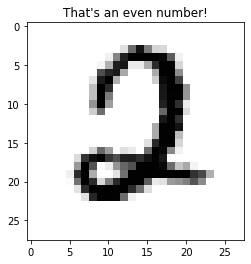

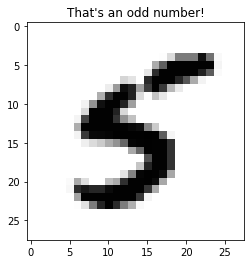

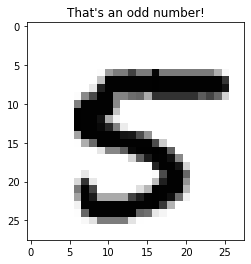

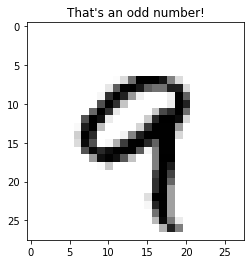

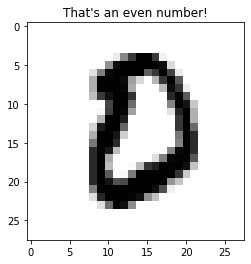

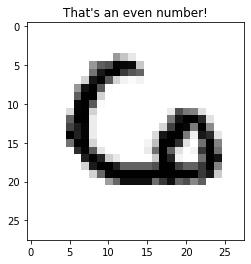

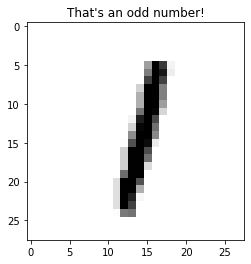

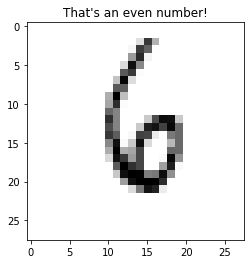

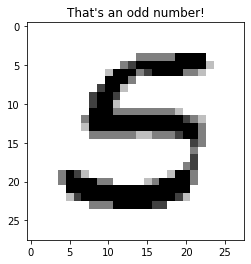

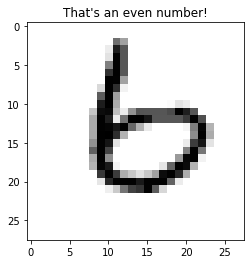

In [9]:
# Let's have a look at some outputs
# Show some example images and whether or not the numbers they contain are odd or even

def predict(image):
    image = image.unsqueeze(0).to(device)
    
    pred = round(model(image).item())
    
    if pred == 0:
        return "That's an even number!"
    else:
        return "That's an odd number!"

        
# Show 10 numbers and their predictions   
dataiter = iter(valloader)
for i in range(0, 10):
    images, labels = dataiter.next()
    result = predict(images[0])
    plt.figure()
    plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
    plt.title(result)